# Week 13 - Neural Networks

Learning contents:
- Convolutional Neural Network
    - Implement the LeNet-5 inspired architecture in PyTorch
- Limited labelled data
    - Rerun the LeNet-5 network with only 100 examples total
- Implement an Autoencoder and train it on the unlabelled data
- Demo: Using the Autoencoder in a multi-task learning setup to improve classification performance.

In [2]:
# Imports you will need
import torch
from math import ceil
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim import SGD
from torch import tanh, flatten
from torch.utils.data import DataLoader, random_split
from torch.nn import Conv2d, AvgPool2d, Linear, Module, ConvTranspose2d, Upsample, Tanh, Sequential
from torch.nn.functional import log_softmax, nll_loss, mse_loss

# Dataset
We'll be using the MNIST dataset again this time:

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('../data', train=False, download=True, transform=transform)

train_loader = DataLoader(
    train_data,
    batch_size = 64,
    shuffle=True,
)

test_loader = DataLoader(
    test_data,
    batch_size = 64,
)

In [5]:
data, targets = next(iter(train_loader))
data.shape, targets.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

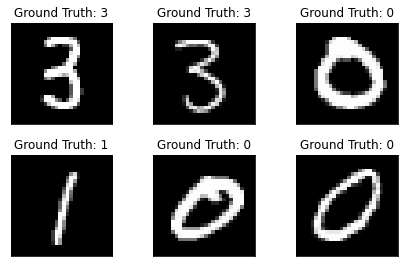

In [6]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(targets[i]))
    plt.xticks([])
    plt.yticks([])

## 1) Convolutional Neural Network
In this exercise, we will implement a Convolutional Neural Network inspired by the LeNet-5 architecture.

![](lenet.png)
Source: http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

Unlike the original architecture, for the subsampling we will use Averarge Pooling, and our output layer will be another Linear layer.

## 1.1) Implement the LeNet-5 inspired architecture in PyTorch
The architecture should consist of the following layers:
- Convolutional layer with  6 neurons, a 5x5 kernel, and stride 1, followed by a tanh function
- Average pooling layer with a 2x2 window size
- Convolutional layer with 16 neurons, a 5x5 kernel, and stride 1, followed by a tanh function
- Average pooling layer with a 2x2 window size
- Fully connected layer with 120 neurons
- Fully connected layer with 84 neurons

In [7]:
class LeNet5(Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Initialise the layers here. Use Conv2d, AvgPool2d, Linear, and Tanh
        # ...
        


    def forward(self, x):
        # Propagate the data through the layers
        # x = self.mylayer(x)
        # ...
        return log_softmax(x, dim=1)

    
def train(
    model:Module, 
    train_loader:DataLoader, 
    optimizer: SGD, 
    epoch:int, 
    log_interval = 50
):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Reset the gradients
        optimizer.zero_grad() 
        
        # Feed the data through the model
        output = model(data) 
        
        # Compute the negative log-likelihood loss
        loss = nll_loss(output, target) 
        
        # Backward propagate the gradients
        loss.backward() 
        
        # Perform an update step using the optimizer
        optimizer.step() 
        
        # Log
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model:Module, test_loader:DataLoader):
    # Set model to evaluation mode
    model.eval()
    
    test_loss = 0
    correct = 0
    
    # Don't accumulate gradients
    with torch.no_grad():
        for data, target in test_loader:
            # Feed the data through the model
            output = model(data)
            
            # Sum up batch loss
            test_loss += nll_loss(output, target, reduction='sum').item()  
            
            # The prediction is the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)  
            
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)
    ))

Train the network for 10 epochs using SGD with a `learning_rate = 0.01` and `momentum = 0.9`.
You should be able to get a 99% accuracy.

In [ ]:
model = LeNet5()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

epochs = 10
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, epoch, log_interval=50)
    test(model, test_loader)

# 2) Limited labelled data
In the previous case, we had plenty of training data (60000 example) to get good performance.
What if we had much less data (100 examples)?

In [9]:
# Generate new datasets
mini_train_size = 100

mini_train_data, rest_train_data = random_split(  
    train_data, [mini_train_size, len(train_data) - mini_train_size]
)

# Our small labelled dataset
mini_train_loader = DataLoader(
    mini_train_data,
    batch_size = 64,
    shuffle=True,
)

# Our larger, unlabbeled dataset
# We will act as if we didn't have labels for this data
rest_train_loader = DataLoader(
    rest_train_data,
    batch_size = 64,
    shuffle=True,
)

## 2.1) Rerun the LeNet-5 network with only 100 examples total
Run it for 200 epochs using the `mini_train_loader`.
What is the test accuracy?

In [56]:
model = LeNet5()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

epochs = 200
for epoch in range(1, epochs + 1):
    train(model, mini_train_loader, optimizer, epoch)
    if epoch % 10 == 0:
        test(model, test_loader)

Train Epoch: 1 [0/100 (0%)]	Loss: 2.283840
Train Epoch: 2 [0/100 (0%)]	Loss: 2.289171
Train Epoch: 3 [0/100 (0%)]	Loss: 2.265617
Train Epoch: 4 [0/100 (0%)]	Loss: 2.257952
Train Epoch: 5 [0/100 (0%)]	Loss: 2.246766
Train Epoch: 6 [0/100 (0%)]	Loss: 2.226400
Train Epoch: 7 [0/100 (0%)]	Loss: 2.222587
Train Epoch: 8 [0/100 (0%)]	Loss: 2.188046
Train Epoch: 9 [0/100 (0%)]	Loss: 2.192306
Train Epoch: 10 [0/100 (0%)]	Loss: 2.184013

Test set: Average loss: 2.2471, Accuracy: 2163/10000 (21.630%)

Train Epoch: 11 [0/100 (0%)]	Loss: 2.146529
Train Epoch: 12 [0/100 (0%)]	Loss: 2.119649
Train Epoch: 13 [0/100 (0%)]	Loss: 2.135626
Train Epoch: 14 [0/100 (0%)]	Loss: 2.101483
Train Epoch: 15 [0/100 (0%)]	Loss: 2.091165
Train Epoch: 16 [0/100 (0%)]	Loss: 2.070218
Train Epoch: 17 [0/100 (0%)]	Loss: 2.000441
Train Epoch: 18 [0/100 (0%)]	Loss: 1.988960
Train Epoch: 19 [0/100 (0%)]	Loss: 1.966821
Train Epoch: 20 [0/100 (0%)]	Loss: 1.978968

Test set: Average loss: 2.0732, Accuracy: 3354/10000 (33.540%)


We end with ≈67% accuracy. NB: due to the small size of training data, the variance of the results may be high.

## 3) Implement an Autoencoder and train it on the unlabelled data
Though we have very little labelled training data, we may have plenty of unlabelled data available (`rest_data_loader`). 
This data can be utilised in many ways; one such way is by using an Autoencoder.

Implement an autoencoder with the following layers:
- Encoder:
    - Convolutional layer with  6 neurons, a 5x5 kernel, and stride 1, followed by a tanh function
    - Average pooling layer with a 2x2 window size
    - Convolutional layer with 16 neurons, a 5x5 kernel, and stride 1, followed by a tanh function
    - Average pooling layer with a 2x2 window size
    - Fully connected layer with 120 neurons
- Decoder:
    - Fully connected layer with 256 neurons
    - Upsample layer with scale-factor 2
    - Transpose convolution with 16 neurons, a 5x5 kernel, and stride 1, followed by a tanh function
    - Upsample layer with scale-factor 2
    - Transpose convolution with 6 neurons, a 5x5 kernel, and stride 1, followed by a tanh function
    
Use the given training code to train check that the implementation works and loss is reduced.

In [48]:
class AutoEncoder(Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder_conv = Sequential(   
            # Initialise the convolutional and pooling layers here
        )
        self.encoder_fc = Linear(???)
        self.decoder_fc = Linear(???)
        self.decoder_conv = Sequential(     
            # Initialise the transpose convolutions and upsampling layers here
        )

    def forward(self, x):
        # Propagate the data through the layers.
        # Hint: beware of the input and output shapes for each layer.
        # You will need to do call `reshape` along the way
        # ...
        
        return x

def train_autoencoder(
    model:Module, 
    train_loader:DataLoader, 
    optimizer: SGD, 
    epoch:int, 
    log_interval = 50
):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        # Reset the gradients
        optimizer.zero_grad() 
        
        # Feed the data through the model
        output = model(data) 
        
        # Compute the negative log-likelihood loss
        loss = mse_loss(output, data) 
        
        # Backward propagate the gradients
        loss.backward() 
        
        # Perform an update step using the optimizer
        optimizer.step() 
        
        # Log
        if batch_idx % log_interval == 0:
            print('AE Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [ ]:
# Check that the auto-encoder works by training it and checking that the loss is reduced
ae_model = AutoEncoder()
optimizer = SGD(ae_model.parameters(), lr=0.01, momentum=0.9)

batch_size = 64
epochs = 1
for epoch in range(1, epochs + 1):
    train_autoencoder(ae_model, rest_train_loader, optimizer, epoch, log_interval=50)

## Demo: Using the Autoencoder in a multi-task learning setup to improve classification performance.
Multitask learning is the learning of multiple tasks in parallel.
What we do here is to integrate the encoding layers of the autoencoder as layers in the LeNet5. We can then train the autoencoder and classification network in parallel in order to improve performance on the classification task.

The code below assumes that you have a working implementation of the Autoencoder.

In [58]:
class AutoEncoderLeNet5(Module):
    def __init__(self, autoencoder):
        super(AutoEncoderLeNet5, self).__init__()
        self.autoencoder = autoencoder
        self.fc2 = Linear(in_features=120, out_features=84)
        self.fc3 = Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.autoencoder.encoder_conv(x)
        x = flatten(x, 1)
        x = self.autoencoder.encoder_fc(x)
        x = tanh(self.fc2(x))
        x = tanh(self.fc3(x))
        return log_softmax(x, dim=1)
    
def train_hybrid(
    model:Module, 
    ae_model:Module,
    labelled_loader:DataLoader,
    unlabelled_loader:DataLoader,
    optimizer: SGD, 
    labelled_steps:int,
    unlabelled_steps:int,
    epoch:int, 
    log_interval = 50
):
    ae_model.train()
    model.train()
    labelled_iter = iter(labelled_loader)
    unlabelled_iter = iter(unlabelled_loader)
    for step in range(1, unlabelled_steps+1):
        if step % labelled_steps == 0:
            labelled_iter = iter(labelled_loader)
            
        data_l, target = next(labelled_iter)
        data_u, _ = next(unlabelled_iter)
        
        # Reset the gradients
        optimizer.zero_grad() 
        
        # Feed the data through the model
        output_u = ae_model(data_u)
        output_l = model(data_l)
        
        # Compute the negative log-likelihood loss
        loss_l = nll_loss(output_l, target) 
        loss_u = mse_loss(output_u, data_u) 
        
        # Backward propagate the gradients
        loss_u.backward() 
        loss_l.backward() 
        
        # Perform an update step using the optimizer
        optimizer.step() 
        
        # Log
        if step % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tULoss: {:.6f} \t LLoss: {:.6f}'.format(
                epoch, step * unlabelled_steps, len(unlabelled_loader.dataset),
                100. * step / unlabelled_steps, loss_u.item(), loss_l.item()))

In [ ]:
ae_model = AutoEncoder()
hybrid_model = AutoEncoderLeNet5(ae_model)
optimizer = SGD(ae_model.parameters(), lr=0.01, momentum=0.9)

batch_size = 64
labelled_steps = ceil(len(mini_train_data) / batch_size)
unlabelled_steps = ceil(len(rest_train_data) / batch_size)
epochs = 5
for epoch in range(1, epochs + 1):
    train_hybrid(hybrid_model, ae_model, mini_train_loader, rest_train_loader, optimizer, labelled_steps, unlabelled_steps, epoch, log_interval=50)
    test(hybrid_model, test_loader)

You should expect an classification accuracy boost of 10-15% compared to using only the `mini_train_loader`.